<a href="https://colab.research.google.com/github/ftriara/MBKM-Startup-Campus/blob/main/regression_amount_purchases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from ast import literal_eval
from scipy import stats
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_clicks = pd.read_csv('/content/drive/MyDrive/MBKM Startup Campus/Data Final Project/Dataset/click_stream.csv')
df_transaksi = pd.read_csv('/content/drive/MyDrive/MBKM Startup Campus/Data Final Project/Dataset/transactions.csv')
df_customer = pd.read_csv('/content/drive/MyDrive/MBKM Startup Campus/Data Final Project/Dataset/customer.csv')

Mounted at /content/drive


# Click Stream

In [ ]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833602 entries, 0 to 12833601
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   session_id      object
 1   event_name      object
 2   event_time      object
 3   event_id        object
 4   traffic_source  object
 5   event_metadata  object
dtypes: object(6)
memory usage: 587.5+ MB


In [ ]:
df_clicks.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [ ]:
df_clicks.isna().sum()

session_id              0
event_name              0
event_time              0
event_id                0
traffic_source          0
event_metadata    8544062
dtype: int64

In [ ]:
df_clicks.drop(['event_name', 'event_id', 'event_metadata'], axis=1, inplace=True)
df_clicks.head()

,session_id,event_time,traffic_source
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,2019-09-06T15:54:32.821085Z,MOBILE
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,2019-09-06T16:03:57.821085Z,MOBILE
2,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:05:10.322763Z,MOBILE
3,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:06:33.322763Z,MOBILE
4,7d440441-e67a-4d36-b324-80ffd636d166,2019-09-01T12:15:29.425431Z,MOBILE


In [ ]:
df_clicks['event_time'] = pd.to_datetime(df_clicks.event_time, cache=True)

# feature engineering waktu dari tiap sesi
df_clicks['minutes_of_session'] = (df_clicks.groupby('session_id')['event_time'].transform(lambda x: x.max() - x.min())).dt.total_seconds() / 60

In [ ]:
df_clicks.drop(['event_time'], axis=1, inplace=True)

In [ ]:
df_clicks.drop_duplicates(inplace=True)
df_clicks.head()

,session_id,traffic_source,minutes_of_session
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,MOBILE,9.416667
2,7d440441-e67a-4d36-b324-80ffd636d166,MOBILE,10.318378
11,f7b5cd60-4f87-4b3c-8bde-c7da8930eec2,MOBILE,448.883333
38,b2843a94-248f-429e-bd54-1a456b4ef4a7,MOBILE,3608.250000
42,d9aaa8a8-5e60-4e1e-ab0a-bb9755a7a3e9,WEB,2412.500000


# Transactions

In [ ]:
df_transaksi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852584 entries, 0 to 852583
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   created_at              852584 non-null  object 
 1   customer_id             852584 non-null  int64  
 2   booking_id              852584 non-null  object 
 3   session_id              852584 non-null  object 
 4   product_metadata        852584 non-null  object 
 5   payment_method          852584 non-null  object 
 6   payment_status          852584 non-null  object 
 7   promo_amount            852584 non-null  int64  
 8   promo_code              326536 non-null  object 
 9   shipment_fee            852584 non-null  int64  
 10  shipment_date_limit     852584 non-null  object 
 11  shipment_location_lat   852584 non-null  float64
 12  shipment_location_long  852584 non-null  float64
 13  total_amount            852584 non-null  int64  
dtypes: float64(2), int64

In [ ]:
df_transaksi.head()

,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753


In [ ]:
# # handling missing values
# nilai_default = "NoCode"
# df_transaksi['promo_code'].fillna(nilai_default, inplace=True)
# df_transaksi.head()

In [ ]:
df_transaksi.isna().sum()

created_at                     0
customer_id                    0
booking_id                     0
session_id                     0
product_metadata               0
payment_method                 0
payment_status                 0
promo_amount                   0
promo_code                526048
shipment_fee                   0
shipment_date_limit            0
shipment_location_lat          0
shipment_location_long         0
total_amount                   0
dtype: int64

In [ ]:
df_transaksi.duplicated().any()

False

In [ ]:
df_transaksi.drop(['product_metadata', 'payment_method', 'payment_status', 'promo_code', 'shipment_date_limit', 'shipment_location_lat',    'shipment_location_long'], axis=1, inplace=True)
df_transaksi.head()

,created_at,customer_id,booking_id,session_id,promo_amount,shipment_fee,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753


In [ ]:
df_transaksi['created_at'] = pd.to_datetime(df_transaksi.created_at, cache=True)

# Customer

In [ ]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null  float64
 12  home_location       100000 non-null  object 
 13  home_country        100000 non-null  object 
 14  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(1), object(12)

In [ ]:
df_customer.head()

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [ ]:
df_customer = df_customer[['customer_id', 'username', 'gender', 'birthdate', 'device_type', 'home_location', 'first_join_date']]
df_customer.head()

,customer_id,username,gender,birthdate,device_type,home_location,first_join_date
0,2870,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,F,1996-06-14,iOS,Sumatera Barat,2019-07-21
1,8193,83be2ba7-8133-48a4-bbcb-b46a2762473f,F,1993-08-16,Android,Jakarta Raya,2017-07-16
2,7279,3250e5a3-1d23-4675-a647-3281879d42be,M,1989-01-23,iOS,Nusa Tenggara Barat,2020-08-23
3,88813,df797edf-b465-4a80-973b-9fbb612260c2,M,1991-01-05,iOS,Kalimantan Timur,2021-10-03
4,82542,36ab08e1-03de-42a8-9e3b-59528c798824,M,2000-07-15,iOS,Kalimantan Selatan,2021-04-11


In [ ]:
df_customer['birthdate'] = pd.to_datetime(df_customer['birthdate'])
df_customer['first_join_date'] = pd.to_datetime(df_customer['first_join_date'])

<ipython-input-20-b19640a9076d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer['birthdate'] = pd.to_datetime(df_customer['birthdate'])
<ipython-input-20-b19640a9076d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer['first_join_date'] = pd.to_datetime(df_customer['first_join_date'])


# Join

In [ ]:
# join dataset transaksi dan customer
df_tc = df_transaksi.merge(df_customer, on='customer_id', how='inner')
df_tc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852584 entries, 0 to 852583
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   created_at       852584 non-null  datetime64[ns, UTC]
 1   customer_id      852584 non-null  int64              
 2   booking_id       852584 non-null  object             
 3   session_id       852584 non-null  object             
 4   promo_amount     852584 non-null  int64              
 5   shipment_fee     852584 non-null  int64              
 6   total_amount     852584 non-null  int64              
 7   username         852584 non-null  object             
 8   gender           852584 non-null  object             
 9   birthdate        852584 non-null  datetime64[ns]     
 10  device_type      852584 non-null  object             
 11  home_location    852584 non-null  object             
 12  first_join_date  852584 non-null  datetime64[ns]     
dtyp

In [ ]:
# feature engineering lama member (pembelian terbaru - tanggal pertama join)
df_tc['created_at'] = df_tc['created_at'].dt.date
df_tc['created_at'] = pd.to_datetime(df_tc['created_at'])
df_tc['length_of_member'] = (df_tc.groupby('customer_id').apply(lambda x: x['created_at'].max() - x['first_join_date']).reset_index(level=0, drop=True)).dt.days
df_tc.drop(['created_at', 'first_join_date'], axis=1, inplace=True)
df_tc.head()

,customer_id,booking_id,session_id,promo_amount,shipment_fee,total_amount,username,gender,birthdate,device_type,home_location,length_of_member
0,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,2000-08-20,Android,Jakarta Raya,1
1,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android,Sulawesi Selatan,1412
2,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android,Sulawesi Selatan,1412
3,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android,Sulawesi Selatan,1412
4,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,5009ab96-84ff-44ef-98b0-c1b492658c29,F,1996-03-15,Android,Sulawesi Selatan,1412


In [ ]:
# feature engineering umur customer
current_year = pd.to_datetime('now').year
df_tc['cust_age'] = current_year - pd.to_datetime(df_tc['birthdate']).dt.year
df_tc.drop(['birthdate'], axis=1, inplace=True)
df_tc.head()

<ipython-input-23-18df6b7e3abd>:2: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  current_year = pd.to_datetime('now').year


,customer_id,booking_id,session_id,promo_amount,shipment_fee,total_amount,username,gender,device_type,home_location,length_of_member,cust_age
0,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,Android,Jakarta Raya,1,23
1,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27
2,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27
3,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27
4,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27


In [ ]:
# join dataset sebelumnya dengan dataset click stream
df = df_tc.merge(df_clicks, on='session_id', how='inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852582 entries, 0 to 852581
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         852582 non-null  int64  
 1   booking_id          852582 non-null  object 
 2   session_id          852582 non-null  object 
 3   promo_amount        852582 non-null  int64  
 4   shipment_fee        852582 non-null  int64  
 5   total_amount        852582 non-null  int64  
 6   username            852582 non-null  object 
 7   gender              852582 non-null  object 
 8   device_type         852582 non-null  object 
 9   home_location       852582 non-null  object 
 10  length_of_member    852582 non-null  int64  
 11  cust_age            852582 non-null  int64  
 12  traffic_source      852582 non-null  object 
 13  minutes_of_session  852582 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 97.6+ MB


In [ ]:
# feature engineering waktu sesi pada tiap 'traffic_source' berdasarkan customer
df['web_session'] = df[df['traffic_source'] == 'WEB'].groupby('customer_id')['minutes_of_session'].transform('sum')
df['mobile_session'] = df[df['traffic_source'] == 'MOBILE'].groupby('customer_id')['minutes_of_session'].transform('sum')

# handling missing values
df['web_session'] = df['web_session'].fillna(df.groupby('customer_id')['web_session'].transform('first'))
df['mobile_session'] = df['mobile_session'].fillna(df.groupby('customer_id')['mobile_session'].transform('first'))

df.drop(['traffic_source'], axis=1, inplace=True)
df['customer_id'].sort_values(ascending=True)
df.head()

,customer_id,booking_id,session_id,promo_amount,shipment_fee,total_amount,username,gender,device_type,home_location,length_of_member,cust_age,minutes_of_session,web_session,mobile_session
0,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,Android,Jakarta Raya,1,23,40.209076,40.209076,NaN
1,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,1.478749,124201.483333,564424.695416
2,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,2.633333,124201.483333,564424.695416
3,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,31131.200000,124201.483333,564424.695416
4,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,39026.933333,124201.483333,564424.695416


In [ ]:
# handling missing values
df['web_session'] = df['web_session'].fillna(0)
df['mobile_session'] = df['mobile_session'].fillna(0)
df.head()

,customer_id,booking_id,session_id,promo_amount,shipment_fee,total_amount,username,gender,device_type,home_location,length_of_member,cust_age,minutes_of_session,web_session,mobile_session
0,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,Android,Jakarta Raya,1,23,40.209076,40.209076,0.000000
1,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,1.478749,124201.483333,564424.695416
2,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,2.633333,124201.483333,564424.695416
3,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,31131.200000,124201.483333,564424.695416
4,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,39026.933333,124201.483333,564424.695416


In [ ]:
# feature engineering rata-rata nilai promo yang digunakan pada tiap customer
df['avg_promo_amount'] = df.groupby('customer_id')['promo_amount'].transform('mean')
df.head()

,customer_id,booking_id,session_id,promo_amount,shipment_fee,total_amount,username,gender,device_type,home_location,length_of_member,cust_age,minutes_of_session,web_session,mobile_session,avg_promo_amount
0,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,Android,Jakarta Raya,1,23,40.209076,40.209076,0.000000,1415.00000
1,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,1.478749,124201.483333,564424.695416,2129.16129
2,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,2.633333,124201.483333,564424.695416,2129.16129
3,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,31131.200000,124201.483333,564424.695416,2129.16129
4,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,39026.933333,124201.483333,564424.695416,2129.16129


In [ ]:
# feature engineering rata-rata ongkos kirim
df['avg_shipment_fee'] = df.groupby('customer_id')['shipment_fee'].transform('mean')
df.head()

,customer_id,booking_id,session_id,promo_amount,shipment_fee,total_amount,username,gender,device_type,home_location,length_of_member,cust_age,minutes_of_session,web_session,mobile_session,avg_promo_amount,avg_shipment_fee
0,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,F,Android,Jakarta Raya,1,23,40.209076,40.209076,0.000000,1415.00000,10000.000000
1,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,1.478749,124201.483333,564424.695416,2129.16129,9193.548387
2,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,2.633333,124201.483333,564424.695416,2129.16129,9193.548387
3,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,31131.200000,124201.483333,564424.695416,2129.16129,9193.548387
4,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,5009ab96-84ff-44ef-98b0-c1b492658c29,F,Android,Sulawesi Selatan,1412,27,39026.933333,124201.483333,564424.695416,2129.16129,9193.548387


In [ ]:
df.drop(['booking_id', 'session_id', 'username', 'promo_amount', 'shipment_fee'], axis=1, inplace=True)

In [ ]:
df['gender'].value_counts()

F    543509
M    309073
Name: gender, dtype: int64

In [ ]:
df['device_type'].value_counts()

Android    656809
iOS        195773
Name: device_type, dtype: int64

In [ ]:
df['home_location'].value_counts()

Jakarta Raya           156698
Jawa Barat             101244
Jawa Tengah             95240
Jawa Timur              81106
Yogyakarta              66444
Kalimantan Barat        46229
Lampung                 45266
Kalimantan Tengah       37249
Kalimantan Selatan      34950
Kalimantan Timur        23743
Maluku                  21656
Kepulauan Riau          17843
Bali                    13750
Sumatera Barat          11139
Nusa Tenggara Barat     11007
Sulawesi Utara          10456
Sumatera Utara           8766
Sulawesi Barat           8152
Sumatera Selatan         7423
Papua                    6904
Papua Barat              6060
Bengkulu                 5865
Sulawesi Selatan         5695
Nusa Tenggara Timur      5004
Gorontalo                3743
Sulawesi Tengah          3489
Maluku Utara             3334
Banten                   3284
Jambi                    3089
Aceh                     2428
Bangka Belitung          2313
Sulawesi Tenggara        1768
Riau                     1245
Name: home

In [ ]:
# categorical encoding
df['gender'].replace(['F', 'M'], [1,0], inplace=True)
df['device_type'].replace(['Android', 'iOS'], [1,2], inplace=True)
df['home_location'].replace(['Jakarta Raya', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Yogyakarta', 'Kalimantan Barat', 'Lampung', 'Kalimantan Tengah', 'Kalimantan Selatan', 'Kalimantan Timur',
                             'Maluku', 'Kepulauan Riau', 'Bali', 'Sumatera Barat', 'Nusa Tenggara Barat', 'Sulawesi Utara', 'Sumatera Utara', 'Sulawesi Barat', 'Sumatera Selatan', 'Papua',
                             'Papua Barat', 'Bengkulu', 'Sulawesi Selatan', 'Nusa Tenggara Timur', 'Gorontalo', 'Sulawesi Tengah', 'Maluku Utara', 'Banten', 'Jambi', 'Aceh', 'Bangka Belitung',
                             'Sulawesi Tenggara', 'Riau'
                             ], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33], inplace=True)
df.head()

,customer_id,total_amount,gender,device_type,home_location,length_of_member,cust_age,minutes_of_session,web_session,mobile_session,avg_promo_amount,avg_shipment_fee
0,5868,199832,1,1,1,1,23,40.209076,40.209076,0.000000,1415.00000,10000.000000
1,4774,155526,1,1,23,1412,27,1.478749,124201.483333,564424.695416,2129.16129,9193.548387
2,4774,550696,1,1,23,1412,27,2.633333,124201.483333,564424.695416,2129.16129,9193.548387
3,4774,271012,1,1,23,1412,27,31131.200000,124201.483333,564424.695416,2129.16129,9193.548387
4,4774,198753,1,1,23,1412,27,39026.933333,124201.483333,564424.695416,2129.16129,9193.548387


In [ ]:
# feature engineering rata-rata waktu sesi berdasarkan 'customer_id'
df['avg_minutes_of_session'] = df.groupby(['customer_id'])['minutes_of_session'].transform('mean')
df.drop('minutes_of_session', axis=1, inplace=True)
df.head()

,customer_id,total_amount,gender,device_type,home_location,length_of_member,cust_age,web_session,mobile_session,avg_promo_amount,avg_shipment_fee,avg_minutes_of_session
0,5868,199832,1,1,1,1,23,40.209076,0.000000,1415.00000,10000.000000,40.209076
1,4774,155526,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702
2,4774,550696,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702
3,4774,271012,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702
4,4774,198753,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702


In [ ]:
# feature engineering total pembelian dari tiap customer
df['total_purchases'] = df.groupby(['customer_id'])['total_amount'].transform('sum')
df.drop(['total_amount'], axis=1, inplace=True)
df.head()

,customer_id,gender,device_type,home_location,length_of_member,cust_age,web_session,mobile_session,avg_promo_amount,avg_shipment_fee,avg_minutes_of_session,total_purchases
0,5868,1,1,1,1,23,40.209076,0.000000,1415.00000,10000.000000,40.209076,199832
1,4774,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702,15038702
2,4774,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702,15038702
3,4774,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702,15038702
4,4774,1,1,23,1412,27,124201.483333,564424.695416,2129.16129,9193.548387,22213.747702,15038702


In [ ]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50704 entries, 0 to 852581
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             50704 non-null  int64  
 1   gender                  50704 non-null  int64  
 2   device_type             50704 non-null  int64  
 3   home_location           50704 non-null  int64  
 4   length_of_member        50704 non-null  int64  
 5   cust_age                50704 non-null  int64  
 6   web_session             50704 non-null  float64
 7   mobile_session          50704 non-null  float64
 8   avg_promo_amount        50704 non-null  float64
 9   avg_shipment_fee        50704 non-null  float64
 10  avg_minutes_of_session  50704 non-null  float64
 11  total_purchases         50704 non-null  int64  
dtypes: float64(5), int64(7)
memory usage: 5.0 MB


In [ ]:
df['customer_id'].nunique()

50704

In [ ]:
df.head(50)

,customer_id,gender,device_type,home_location,length_of_member,cust_age,web_session,mobile_session,avg_promo_amount,avg_shipment_fee,avg_minutes_of_session,total_purchases
0,5868,1,1,1,1,23,40.209076,0.000000,1415.000000,10000.000000,40.209076,199832
1,4774,1,1,23,1412,27,124201.483333,564424.695416,2129.161290,9193.548387,22213.747702,15038702
32,58191,0,1,15,1441,10,49397.050000,626955.461912,1814.917526,10463.917526,6972.706308,47553651
129,81104,1,1,2,0,28,0.000000,25.176534,0.000000,10000.000000,25.176534,195705
130,47040,1,1,10,977,25,0.000000,368436.166324,3482.666667,15000.000000,122812.055441,545304
133,11016,0,1,27,733,34,5.396137,266620.900000,0.000000,7500.000000,133313.148068,290946
135,24915,0,2,8,1174,38,0.000000,488714.092839,3655.800000,6000.000000,97742.818568,5464710
140,76966,1,1,8,1415,38,63180.666667,481479.732134,2782.598039,8774.509804,5339.807831,51861585
242,56690,0,1,1,1378,18,99333.350000,689342.435824,2020.000000,11176.470588,46392.693284,15758445
259,38579,1,1,8,1099,25,0.000000,775417.816935,3316.000000,11250.000000,193854.454234,1819417


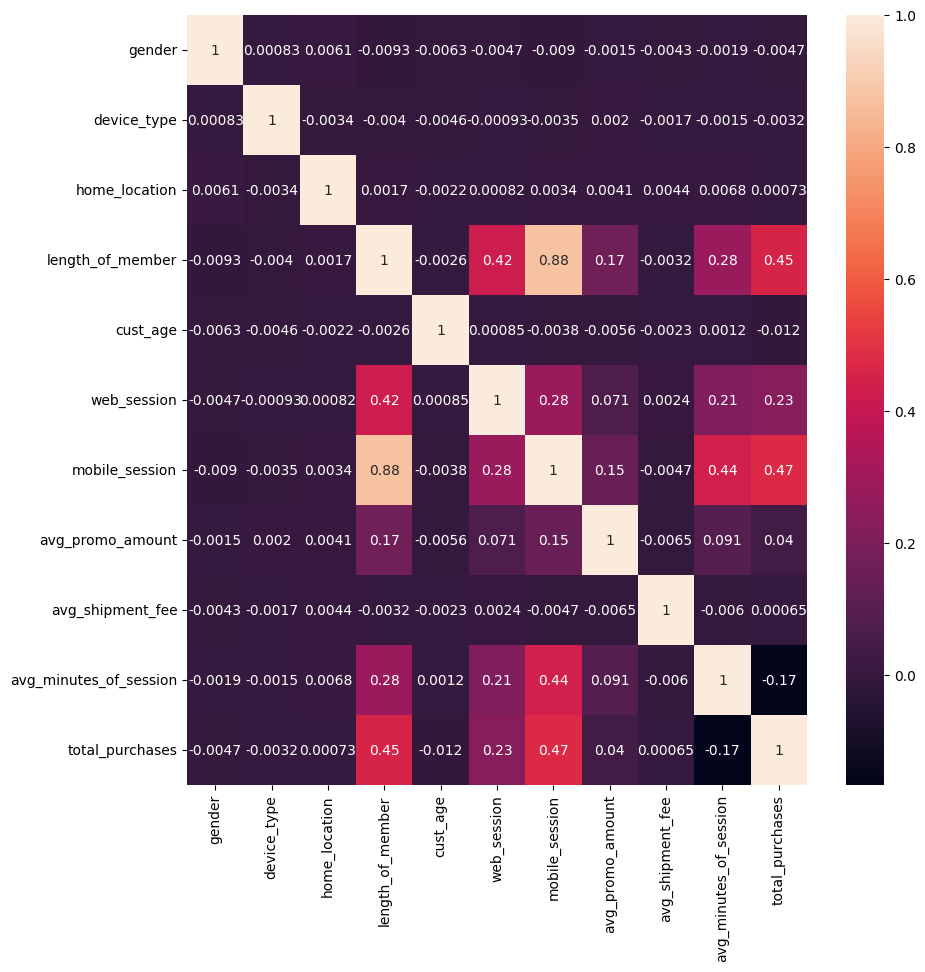

In [ ]:
# mengecek korelasi antar kolom dalam data numerik menggunakan heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(df.drop('customer_id', axis=1).corr(), annot = True)
plt.show()

# Modelling

In [ ]:
# import library
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, learning_curve, GridSearchCV
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# mendefinisikan variabel independen (X) dan variabel target (y)
X = df.drop(['total_purchases'],axis=1)
y = df['total_purchases']

1. Decision Tree

In [ ]:
# membagi data menjadi 2 untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=22)

print("Training Set - X_train shape:", X_train.shape)
print("Testing Set - X_test shape:", X_test.shape)
print("Training Set - y_train shape:", y_train.shape)
print("Testing Set - y_test shape:", y_test.shape)

Training Set - X_train shape: (43098, 11)
Testing Set - X_test shape: (7606, 11)
Training Set - y_train shape: (43098,)
Testing Set - y_test shape: (7606,)


In [ ]:
# modelling
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

DecisionTreeRegressor()

Mean Absolute Error (MAE): 2904971.729
Cross-Validation MAE:  [-2890510.47366589 -2909650.31809745 -2941753.76542923 -2863376.6780369
 -2958357.37208493]
Average Cross Validation MAE:  -2912729.72146288


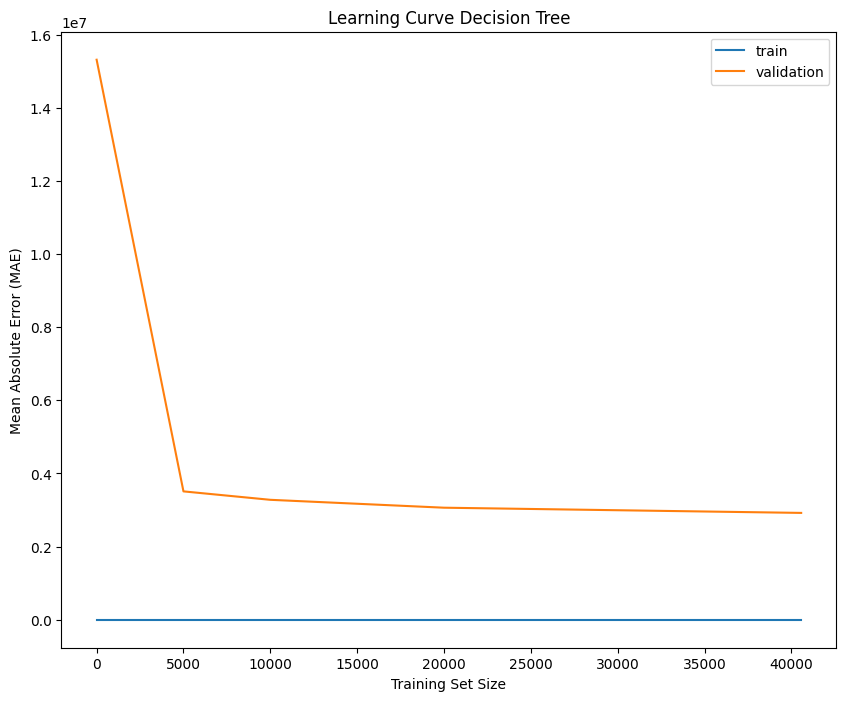

In [ ]:
# MAE model dasar
y_dt_pred = dt.predict(X_test)
mae_dt = mean_absolute_error(y_test, y_dt_pred)
print('Mean Absolute Error (MAE):', round(mae_dt, 4))

# cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# implement cross validation
cv_score1 = cross_val_score(dt, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

# print result
print("Cross-Validation MAE: ", cv_score1)
print("Average Cross Validation MAE: ", np.mean(cv_score1))

# generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=dt,
    X=X,
    y=y,
    cv=cv,
    scoring="neg_mean_absolute_error",
    train_sizes = [1, 5000, 10000, 20000, 40563]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")
plt.title("Learning Curve Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend(loc="best")
plt.show()

2. Random Forest Regressor

In [ ]:
# membagi data menjadi 2 untuk training dan testing
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.15, random_state=22)

In [ ]:
# modelling
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor()

Mean Absolute Error (MAE): 2150650.6184
Cross-Validation MAE:  [-2142098.17335267 -2102439.38014849 -2157157.038058   -2116073.30168233
 -2133102.77752059]
Average Cross Validation MAE:  -2130174.1341524175


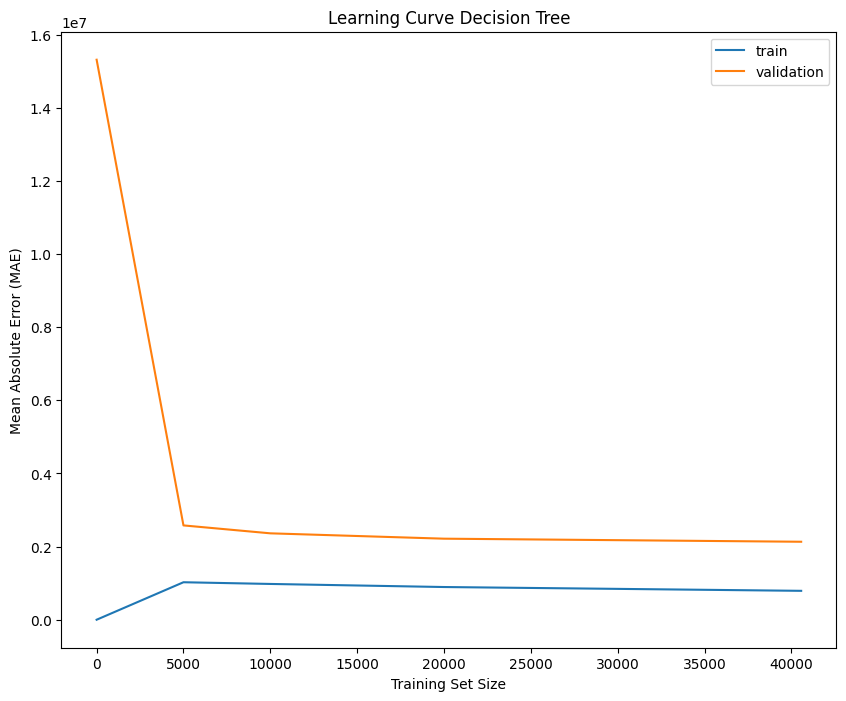

In [ ]:
# MAE model dasar
y_rfr_pred = rfr.predict(X_test)
mae_rfr = mean_absolute_error(y_test, y_rfr_pred)
print('Mean Absolute Error (MAE):', round(mae_rfr, 4))

# cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# implement cross validation
cv_score2 = cross_val_score(rfr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

# print result
print("Cross-Validation MAE: ", cv_score2)
print("Average Cross Validation MAE: ", np.mean(cv_score2))

# generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rfr,
    X=X,
    y=y,
    cv=cv,
    scoring="neg_mean_absolute_error",
    train_sizes = [1, 5000, 10000, 20000, 40563]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")
plt.title("Learning Curve Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend(loc="best")
plt.show()

3. Gradient Boosting Regressor

In [ ]:
# membagi data menjadi 2 untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=22)

In [ ]:
# modelling
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)

GradientBoostingRegressor()

Mean Absolute Error (MAE): 2189284.8152
Cross-Validation MAE:  [-2195816.51148718 -2197151.864558   -2206480.50359861 -2149069.39839788
 -2163766.16935901]
Average Cross Validation MAE:  -2182456.8894801345


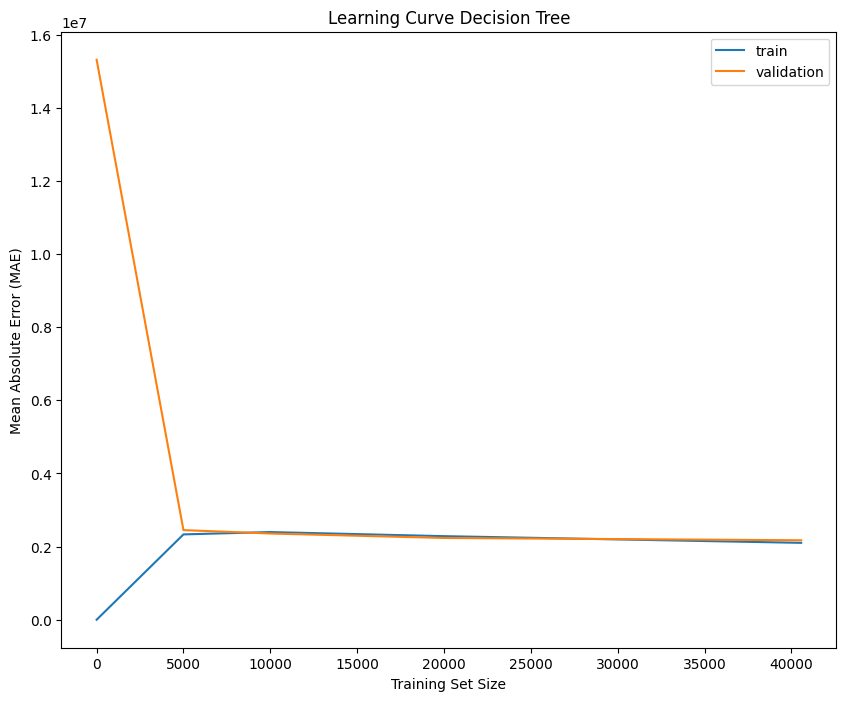

In [ ]:
# MAE model dasar
y_gbr_pred = gbr.predict(X_test)
mae_gbr = mean_absolute_error(y_test, y_gbr_pred)
print('Mean Absolute Error (MAE):', round(mae_gbr, 4))

# cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# implement cross validation
cv_score3 = cross_val_score(gbr, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

# print result
print("Cross-Validation MAE: ", cv_score3)
print("Average Cross Validation MAE: ", np.mean(cv_score3))

# generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=gbr,
    X=X,
    y=y,
    cv=cv,
    scoring="neg_mean_absolute_error",
    train_sizes = [1, 5000, 10000, 20000, 40563]
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_mean, label="train")
plt.plot(train_sizes, test_mean, label="validation")
plt.title("Learning Curve Decision Tree")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend(loc="best")
plt.show()